In [46]:
%load_ext autoreload
%autoreload 2
import time
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Interface Running...


In [47]:
robot.getStates()

{'q': array([ 1.76623102e-03, -7.84020556e-01,  9.17066017e-03, -2.52492266e+00,
        -2.73416204e-03,  1.56506182e+00,  7.84983352e-01]),
 'dq': array([ 0.00205476, -0.00049763,  0.00131447, -0.00060757,  0.00057075,
        -0.00068269,  0.00190916]),
 'T': array([-0.11178899, -4.39721823, -0.9541229 , 23.45279312,  0.84886396,
         1.9225843 ,  0.10119084])}

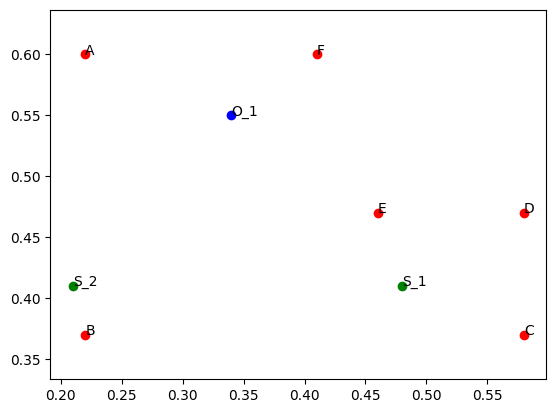

In [48]:
import numpy as np
dist_to_surface = -0.005

P_A = np.array([0.22, 0.60, 0.01])
P_B = np.array([0.22, 0.37, 0.01])
P_C = np.array([0.58, 0.37, 0.01])
P_D = np.array([0.58, 0.47, 0.01])
P_E = np.array([0.46, 0.47, 0.01])
P_F = np.array([0.41, 0.60, 0.01])
S_1 = np.array([0.48, 0.41, 0.01])
S_2 = np.array([0.21, 0.41, 0.01])
O_1 = np.array([0.34, 0.55, 0.01])

# plot these points in matplotlib with their names next to these points
import matplotlib.pyplot as plt

plt.plot(P_A[0], P_A[1], 'ro')
plt.text(P_A[0], P_A[1], 'A')
plt.plot(P_B[0], P_B[1], 'ro')
plt.text(P_B[0], P_B[1], 'B')
plt.plot(P_C[0], P_C[1], 'ro')
plt.text(P_C[0], P_C[1], 'C')
plt.plot(P_D[0], P_D[1], 'ro')
plt.text(P_D[0], P_D[1], 'D')
plt.plot(P_E[0], P_E[1], 'ro')
plt.text(P_E[0], P_E[1], 'E')
plt.plot(P_F[0], P_F[1], 'ro')
plt.text(P_F[0], P_F[1], 'F')

plt.plot(S_1[0], S_1[1], 'go')
plt.text(S_1[0], S_1[1], 'S_1')
plt.plot(S_2[0], S_2[1], 'go')
plt.text(S_2[0], S_2[1], 'S_2')
plt.plot(O_1[0], O_1[1], 'bo')
plt.text(O_1[0], O_1[1], 'O_1')

plt.axis('equal')
plt.show()




In [49]:
from FR3Py.robot.model_collision_avoidance import PinocchioModel

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)
P_EE_pre_wiping = S_1
P_EE_initial = np.array([0.30, 0.0, 0.47])
R_EE_pre_wiping = np.array([[0, 1, 0],
                            [1, 0, 0],
                            [0, 0, -1]])
R_EE_initial = np.array([[1, 0, 0],
                        [0, -1, 0],
                        [0, 0, -1]])


### Inverse dynamic control (initial pose to pre-cleaning pose)

In [50]:
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
from liegroups import SO3

via_points = np.array([P_EE_initial, P_EE_pre_wiping])
target_time = np.array([0, 10])
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

target_time = np.array([0, 8])
orientations = np.array([R_EE_initial, R_EE_pre_wiping])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=0.01)


In [51]:
T = 12

K_p_pos = np.diag([100,100,100])
K_d_pos = np.diag([50,50,50])

K_p_rot = np.diag([200,200,200])
K_d_rot = np.diag([100,100,100])

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    q_dtdt = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Map to torques
    u = M @ q_dtdt
    
    u = np.clip(u, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))


### Press against the surface while tracking a back-and-forth trajectory with friction compensation

In [52]:
duration = 100
dist_to_surface = -0.005
P_EE_pre_wiping = np.array([S_1[0], S_1[1], dist_to_surface])
P_EE_end_wiping = np.array([S_2[0], S_2[1], dist_to_surface])
N_back_and_forth = 20
via_points = np.zeros((N_back_and_forth,3))
target_time = np.linspace(0, duration, N_back_and_forth+1)
for i in range(N_back_and_forth):
    if i % 2 == 0:
        via_points[i,:] = P_EE_pre_wiping
    else:
        via_points[i,:] =P_EE_end_wiping

traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)


In [53]:
from cores.utils.proxsuite_utils import init_proxsuite_qp
import diffOptHelper as doh

# Load the obstacle
obs_pos_2d = np.array([0.34, 0.55])
obs_size_2d = np.array([0.1, 0.1])
obs_orientation_2d = np.deg2rad(0)
obs_R_2d = np.array([[np.cos(obs_orientation_2d), -np.sin(obs_orientation_2d)],
                    [np.sin(obs_orientation_2d), np.cos(obs_orientation_2d)]]) 
obs_coef_2d = obs_R_2d @ np.diag(1/obs_size_2d**2) @ obs_R_2d.T

# Load the bounding shape 
eraser_bb_size_2d = np.array([0.088, 0.035])
eraser_D_2d = np.diag(1/eraser_bb_size_2d**2)

# Initiate QP
n_CBF = 1
cbf_qp = init_proxsuite_qp(n_v=n_joints, n_eq=3, n_in=n_CBF + n_joints)

# CBF parameters
alpha0 = [1.1]
gamma1 = [5.0]
gamma2 = [5.0]
compensation = [0]

In [58]:
T = 60

dt = 0.01

R_d = R_EE_pre_wiping

K_p_pos = np.diag([100,100,50])
K_d_pos = np.diag([50,50,25])

K_p_rot = np.diag([200,200,200])
K_d_rot = np.diag([100,100,100])

Kp_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 5*np.diag([1, 1, 1, 1, 1, 1, 1])

F_press = np.array([0, 0, 0, 0, 0, 0])

mu_friction = 0.305 # 0.305

CBF_active = True

# Records
states_2d_list = []
pos_list = []
u_list = []
t_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj_position.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    tau_m = robot_info["T"] # shape (6,)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)
    tau_ext = tau_m - nle

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_vel # shape (3,)
    v_dt = traj_acc - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ R_d.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] # shape (3,)
    omega_dt = -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_desired = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Filter q_dtdt to be safe
    theta_2d = np.arctan2(pin_info["R_EE"][1,0], pin_info["R_EE"][0,0])
    states = np.array([P_EE[0], P_EE[1], theta_2d])
    states_dt = np.array([v_EE[0], v_EE[1], v_EE[5]])

    if CBF_active:
        # Matrices for the CBF-QP constraints
        C = np.zeros([n_CBF+n_joints, n_joints])
        lb = np.zeros(n_CBF+n_joints)
        ub = np.zeros(n_CBF+n_joints)
        A = np.zeros([3, n_joints])
        b = np.zeros(3)
        CBF_tmp = np.zeros(n_CBF)
        phi1_tmp = np.zeros(n_CBF)
        phi2_tmp = np.zeros(n_CBF)

        for kk in range(n_CBF):
            eraser_pos_2d = states[0:2]
            eraser_theta = states[2]
            eraser_R_2d = np.array([[np.cos(eraser_theta), -np.sin(eraser_theta)],
                                    [np.sin(eraser_theta), np.cos(eraser_theta)]])
            alpha, _, alpha_dx_tmp, alpha_dxdx_tmp = doh.getGradientAndHessianEllipses(eraser_pos_2d, eraser_theta, eraser_D_2d,
                                                                                    eraser_R_2d, obs_coef_2d, obs_pos_2d)

            # Order of parameters in alpha_dx_tmp and alpha_dxdx_tmp: [theta, x, y]
            # Convert to the order of [x, y, theta]
            alpha_dx = np.zeros(3)
            alpha_dx[0:2] = alpha_dx_tmp[1:3]
            alpha_dx[2] = alpha_dx_tmp[0]

            alpha_dxdx = np.zeros((3, 3))
            alpha_dxdx[0:2,0:2] = alpha_dxdx_tmp[1:3,1:3]
            alpha_dxdx[2,2] = alpha_dxdx_tmp[0,0]
            alpha_dxdx[0:2,2] = alpha_dxdx_tmp[0,1:3]
            alpha_dxdx[2,0:2] = alpha_dxdx_tmp[1:3,0]

            # CBF-QP constraints
            CBF_dt =  alpha_dx @ states_dt # scalar
            CBF = alpha - alpha0[kk]
            phi1 = CBF_dt + gamma1[kk] * CBF

            C[kk,:] = alpha_dx @ J_EE[[0,1,5],:]
            lb[kk] = - gamma2[kk]*phi1 - gamma1[kk]*CBF_dt - states_dt.T @ alpha_dxdx @ states_dt - alpha_dx @ dJdq_EE[[0,1,5]] + compensation[kk]
            ub[kk] = np.inf

            CBF_tmp[kk] = CBF
            phi1_tmp[kk] = phi1

        # Constraints on joint limits
        for kk in range(n_joints):
            C[n_CBF+kk,kk] = 1/2*dt**2
            lb[n_CBF+kk] = joint_lb[kk] - dq[kk]*dt - q[kk]
            ub[n_CBF+kk] = joint_ub[kk] - dq[kk]*dt - q[kk]

        # CBF-QP constraints
        A = J_EE[[2,3,4],:]
        b = v_EE_dt_desired[[2,3,4]] - dJdq_EE[[2,3,4]]
        g = -q_dtdt_desired
        cbf_qp.update(g=g, C=C, l=lb, u=ub, A=A, b=b)
        time_cbf_qp_start = time.time()
        cbf_qp.solve()
        time_cbf_qp_end = time.time()
        q_dtdt_task = cbf_qp.results.x
        for kk in range(n_CBF):
            phi2_tmp[kk] = C[kk,:] @ q_dtdt_task - lb[kk]
        
    else:
        q_dtdt_task = q_dtdt_desired
        time_cbf_qp_start = 0
        time_cbf_qp_end = 0
        CBF_tmp = np.zeros(n_CBF)
        phi1_tmp = np.zeros(n_CBF)
        phi2_tmp = np.zeros(n_CBF)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq

    # Calculate overall q_dtdt
    q_dtdt = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Other objective 1: apply a force on the z axis to press the end-effector against the table
    u_press = J_EE.T @ F_press

    # Other objective 2: apply a force to compensate for the friction
    F_ext = np.linalg.pinv(J_EE.T) @ tau_ext
    z_force = F_ext[2]
    F_friction = np.zeros(6)
    if z_force < 0 and np.linalg.norm(v_EE[0:2]) > 0.01:
        friction = mu_friction * np.abs(z_force)
        direction = v_EE[0:2]/np.linalg.norm(v_EE[0:2])
        F_friction[0:2] = direction * friction
    if z_force < 0 and abs(v_EE[5]) > 0.01:
        F_friction[5] = np.sign(v_EE[5]) * mu_friction * abs(z_force) * 0.03534
    u_friction = J_EE.T @ F_friction

    # Map to torques
    u = M @ q_dtdt + u_press + u_friction
    u = np.clip(u, -10, 10)
    robot.setCommands(u)

    t_list.append(t)
    pos_list.append(P_EE)
    u_list.append(u)
    states_2d_list.append(states)

robot.setCommands(np.zeros_like(u))


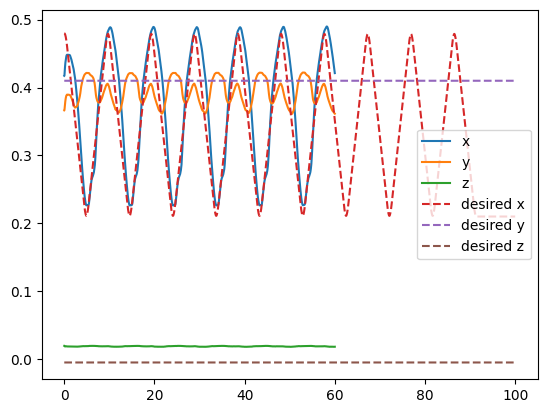

In [59]:
import matplotlib.pyplot as plt

pos_list = np.array(pos_list)
u_list = np.array(u_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, pos_list[:,0], label='x')
plt.plot(t_list, pos_list[:,1], label='y')
plt.plot(t_list, pos_list[:,2], label='z')
plt.plot(traj_position.t, traj_position.pd[:,0], '--', label='desired x')
plt.plot(traj_position.t, traj_position.pd[:,1], '--', label='desired y')
plt.plot(traj_position.t, traj_position.pd[:,2], '--', label='desired z')
plt.legend()



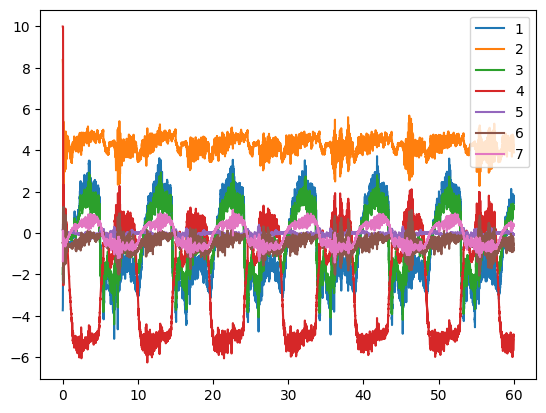

In [60]:

plt.figure()
plt.plot(t_list, u_list[:,0], label='1')
plt.plot(t_list, u_list[:,1], label='2')
plt.plot(t_list, u_list[:,2], label='3')
plt.plot(t_list, u_list[:,3], label='4')
plt.plot(t_list, u_list[:,4], label='5')
plt.plot(t_list, u_list[:,5], label='6')
plt.plot(t_list, u_list[:,6], label='7')

plt.legend()


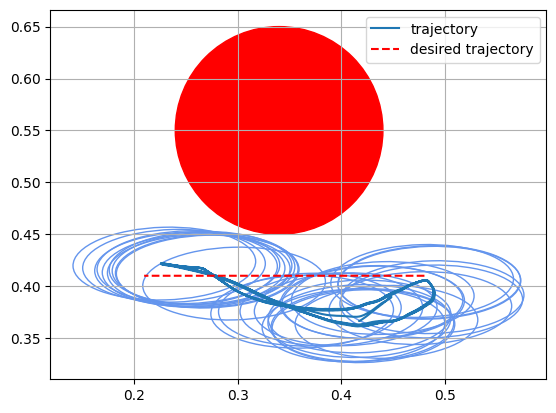

In [61]:
from matplotlib.patches import Ellipse
states_2d_list = np.array(states_2d_list)
fig, ax = plt.subplots()
ellipse = Ellipse(xy=(obs_pos_2d[0], obs_pos_2d[1]), width=2*obs_size_2d[0], height=2*obs_size_2d[1], color='r') 
ax.plot(states_2d_list[:,0], states_2d_list[:,1], label='trajectory')
ax.plot(traj_position.pd[:,0], traj_position.pd[:,1], color='r', linestyle='--', label='desired trajectory')
ax.add_patch(ellipse)

N_recs = 30
sampled = np.linspace(0, len(states_2d_list)-1, N_recs).astype(int)
for i in range(N_recs):
    x = states_2d_list[sampled[i],0]
    y = states_2d_list[sampled[i],1]
    angle = states_2d_list[sampled[i],2]
    ellipse = Ellipse(xy=(x,y), width=2*eraser_bb_size_2d[0], height=2*eraser_bb_size_2d[1], angle=angle,edgecolor='cornflowerblue', facecolor='none')
    ax.add_patch(ellipse)

ax.grid()
ax.set_aspect('equal')
ax.legend()

### Recover to initial pose

In [44]:
via_points = np.array([P_EE, np.array([P_EE[0], P_EE[1], P_EE[2]+0.2])])
target_time = np.array([0, 5])
traj = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [45]:
from liegroups import SO3

T = 7

K_p_pos = np.diag([100,100,100])
K_d_pos = np.diag([50,50,50])

K_p_rot = np.diag([100,100,100])
K_d_rot = np.diag([50,50,50])

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_vel # shape (3,)
    v_dt = traj_acc - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ R_EE.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] # shape (3,)
    omega_dt = -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    q_dtdt_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    q_dtdt = q_dtdt_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Map to torques
    u = M @ q_dtdt
    
    u = np.clip(u, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))
